#### Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")

#### Data

In [2]:
tx = pd.read_csv("merged-df.csv")                       # transactions
users = pd.read_csv("final_features_with_clusters.csv") # user-level with Cluster

print("tx shape:", tx.shape)
print("users shape:", users.shape)
print("tx columns:", tx.columns)
print("users columns:", users.columns)

tx shape: (13305915, 36)
users shape: (1219, 33)
tx columns: Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city',
       'merchant_state', 'zip', 'mcc', 'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address', 'user_latitude', 'user_longitude',
       'user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'user_credit_score', 'user_num_credit_cards',
       'card_card_brand', 'card_card_type', 'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date', 'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')
users columns: Index(['user_id', 'total_txn_count', 'total_amount', 'avg_amount', 'std_amount', 'median_amount', 'first_txn',
       'last_txn', 'user_gender', 'user_current_age', 'user_birth_year', 'user_yearly_income',
       'user_per_capita_i

In [3]:
tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
print("tx date range:", tx['date'].min(), "→", tx['date'].max())

tx date range: 2010-01-01 00:01:00 → 2019-10-31 23:59:00


#### Final df with clusters

In [4]:
cluster_map = users[['user_id', 'Cluster']].drop_duplicates()
df = tx.merge(cluster_map, on='user_id', how='left')

In [5]:
df

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,description,category,user_current_age,user_retirement_age,user_birth_year,user_birth_month,user_gender,user_address,user_latitude,user_longitude,user_per_capita_income,user_yearly_income,user_total_debt,user_credit_score,user_num_credit_cards,card_card_brand,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web,Cluster
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0000,Swipe Transaction,59935,Beulah,ND,58523,5499,Miscellaneous Food Stores,Food & Dining,30,67,1989,7,Female,594 Mountain View Street,46.8000,-100.7600,"23,679.0000","48,277.0000","110,153.0000",740,4,Mastercard,Debit (Prepaid),YES,306,2022-07-01,2,55.0000,2008-05-01,2008,No,3
1,7475328,2010-01-01 00:02:00,561,4575,14.5700,Swipe Transaction,67570,Bettendorf,IA,52722,5311,Department Stores,Shopping & Retail,48,67,1971,6,Male,604 Pine Street,40.8000,-91.1200,"18,076.0000","36,853.0000","112,139.0000",834,5,Mastercard,Credit,YES,438,2024-12-01,1,"9,100.0000",2005-09-01,2015,No,3
2,7475329,2010-01-01 00:02:00,1129,102,80.0000,Swipe Transaction,27092,Vista,CA,92084,4829,Money Transfer,Financial & Insurance,49,65,1970,4,Male,2379 Forest Lane,33.1800,-117.2900,"16,894.0000","34,449.0000","36,540.0000",686,3,Mastercard,Debit,YES,256,2020-05-01,1,"14,802.0000",2006-01-01,2008,No,2
3,7475331,2010-01-01 00:05:00,430,2860,200.0000,Swipe Transaction,27092,Crown Point,IN,46307,4829,Money Transfer,Financial & Insurance,52,67,1967,5,Female,903 Hill Boulevard,41.4200,-87.3500,"26,168.0000","53,350.0000","128,676.0000",685,5,Mastercard,Debit,NO,54,2024-10-01,2,"37,634.0000",2004-05-01,2006,No,0
4,7475332,2010-01-01 00:06:00,848,3915,46.4100,Swipe Transaction,13051,Harwood,MD,20776,5813,Drinking Places (Alcoholic Beverages),Food & Dining,51,69,1968,5,Male,166 River Drive,38.8600,-76.6000,"33,529.0000","68,362.0000","96,182.0000",711,2,Visa,Debit,YES,120,2020-01-01,1,"19,113.0000",2009-07-01,2014,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.1100,Chip Transaction,86438,West Covina,CA,91792,5499,Miscellaneous Food Stores,Food & Dining,81,67,1938,11,Female,766 Third Drive,34.0200,-117.8900,"22,681.0000","33,483.0000",196.0000,698,5,Mastercard,Debit,YES,992,2020-02-01,1,"26,743.0000",2019-03-01,2019,No,0
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.8000,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,"Digital Goods - Media, Books, Apps",Entertainment & Recreation,62,66,1957,9,Male,6076 Bayview Boulevard,43.0600,-87.9600,"9,995.0000","20,377.0000","12,092.0000",789,4,Mastercard,Debit,YES,91,2024-06-01,1,"5,141.0000",2004-03-01,2012,No,1
13305912,23761870,2019-10-31 23:57:00,199,1031,40.4400,Swipe Transaction,2925,Allen,TX,75002,4900,"Utilities - Electric, Gas, Water, Sanitary",Home & Utilities,67,67,1952,4,Female,7927 Plum Lane,33.1000,-96.6600,"32,580.0000","78,329.0000","40,161.0000",720,3,Mastercard,Debit,YES,908,2021-06-01,1,"17,686.0000",2004-02-01,2007,No,1
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.0000,Chip Transaction,46284,Daly City,CA,94014,5411,"Grocery Stores, Supermarkets",Food & Dining,44,69,1975,12,Female,5887 Seventh Lane,37.6800,-122.4300,"23,752.0000","48,430.0000","62,384.0000",716,2,Visa,Debit,YES,762,2021-11-01,2,"14,036.0000",2005-11-01,2010,No,1


#### exclude refunds (negative amounts)

In [6]:
before = len(df)
df = df[df['amount'] > 0].copy()
after = len(df)
print(f"Removed refunds: {before-after:,} rows ({100*(before-after)/before:.2f}%)")

Removed refunds: 670,688 rows (5.04%)


#### Aggregate to Cluster × Month (target series)

In [7]:
cluster_monthly = (
    df.groupby(['Cluster', pd.Grouper(key='date', freq='M')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'amount':'total_amount'})
      .sort_values(['Cluster','date'])
)
cluster_monthly.tail()

,Cluster,date,total_amount
467,3,2019-06-30,"1,033,032.6900"
468,3,2019-07-31,"1,061,661.1600"
469,3,2019-08-31,"1,061,982.1400"
470,3,2019-09-30,"1,036,589.8500"
471,3,2019-10-31,"1,070,379.6700"


In [8]:
# 0) Make sure your 'date' is month-end aligned and datetime
cluster_monthly = cluster_monthly.copy()
cluster_monthly['date'] = pd.to_datetime(cluster_monthly['date']).dt.to_period('M').dt.to_timestamp('M')

# 1) Compute expected vs actual months per cluster correctly
def expected_months_count(start_ts, end_ts):
    return len(pd.period_range(start=start_ts, end=end_ts, freq='M'))  # inclusive count

ranges = (
    cluster_monthly.groupby('Cluster')['date']
    .agg(start='min', end='max')
    .reset_index()
)
ranges['expected_months'] = ranges.apply(lambda r: expected_months_count(r['start'], r['end']), axis=1)
actual = cluster_monthly.groupby('Cluster')['date'].nunique().reset_index(name='actual_months')
check = ranges.merge(actual, on='Cluster', how='left')
check['missing_months'] = check['expected_months'] - check['actual_months']
print(check)

   Cluster      start        end  expected_months  actual_months  missing_months
0        0 2010-01-31 2019-10-31              118            118               0
1        1 2010-01-31 2019-10-31              118            118               0
2        2 2010-01-31 2019-10-31              118            118               0
3        3 2010-01-31 2019-10-31              118            118               0


### No missing months in df

#### Quick EDA of composition

In [9]:
# Users' first/last txn and tenure (overview)
user_lifetimes = (
    df.groupby('user_id')['date']
      .agg(first_txn='min', last_txn='max')
      .reset_index()
)
user_lifetimes['tenure_days'] = (user_lifetimes['last_txn'] - user_lifetimes['first_txn']).dt.days
print(user_lifetimes['tenure_days'].describe())

count   1,219.0000
mean    3,491.8261
std       361.3576
min       852.0000
25%     3,589.0000
50%     3,590.0000
75%     3,590.0000
max     3,590.0000
Name: tenure_days, dtype: float64


- Most users were active through the full time range
- min = 852 --> A few joined late (maybe around 2017)

### Exploratory Analysis

#### 1. Total Spending Variation per Cluster

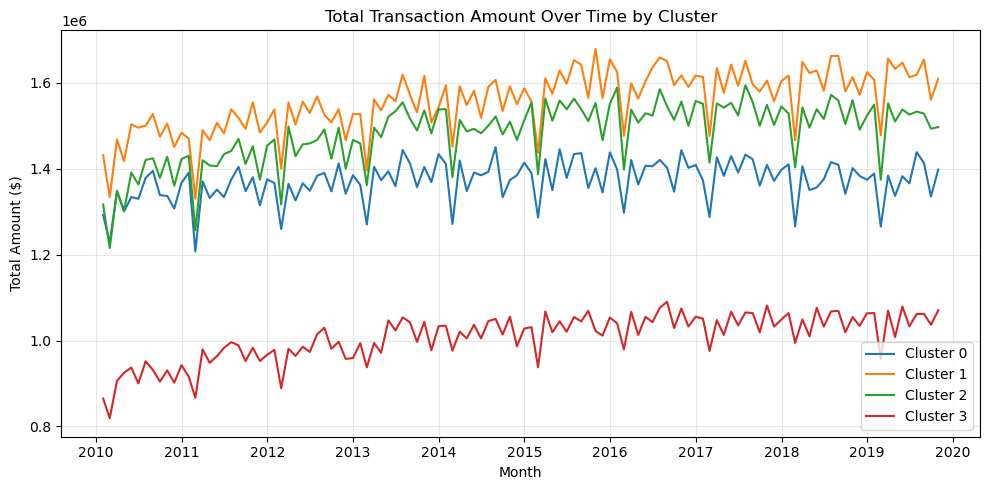

In [10]:
plt.figure(figsize=(10,5))

for c in cluster_monthly['Cluster'].unique():
    sub = cluster_monthly[cluster_monthly['Cluster']==c]
    plt.plot(sub['date'], sub['total_amount'], label=f'Cluster {c}')

plt.title('Total Transaction Amount Over Time by Cluster')
plt.xlabel('Month')
plt.ylabel('Total Amount ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- exhibits seasonality
- clusters are separated by spending totals

#### 2. Rolling Mean & Variance per Cluster

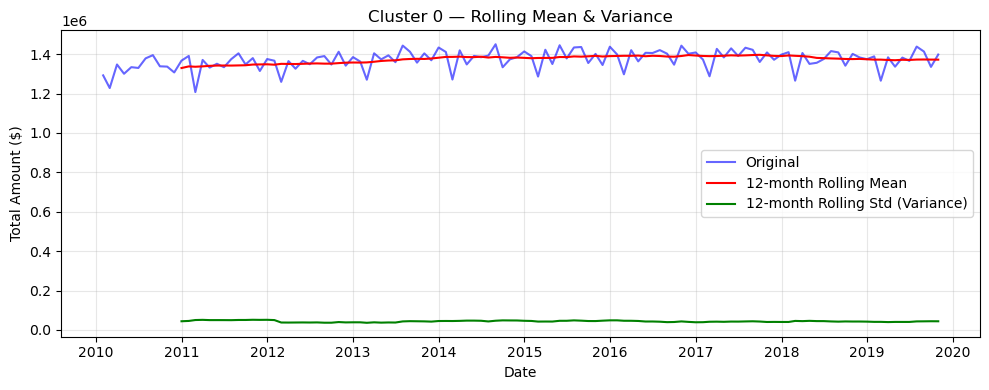

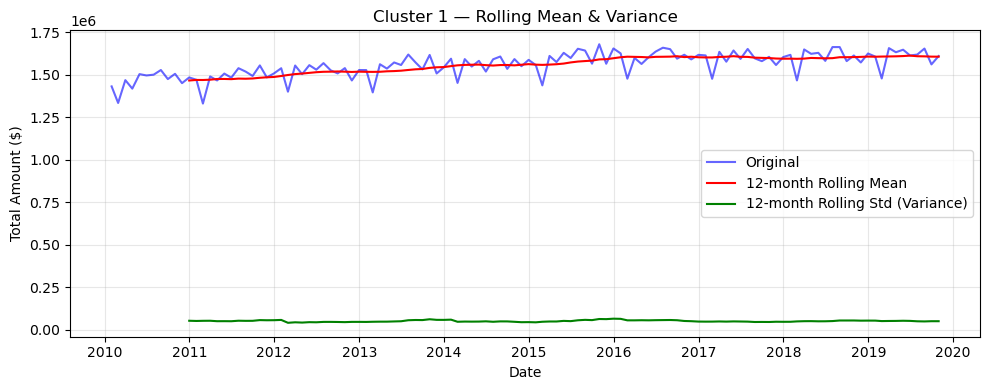

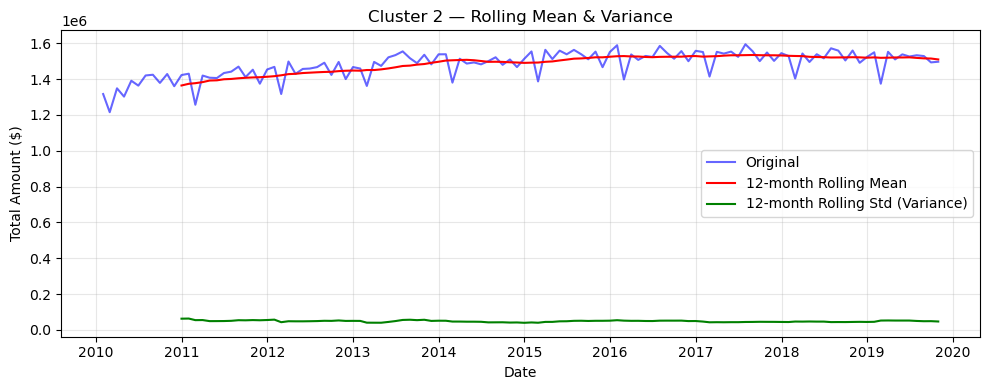

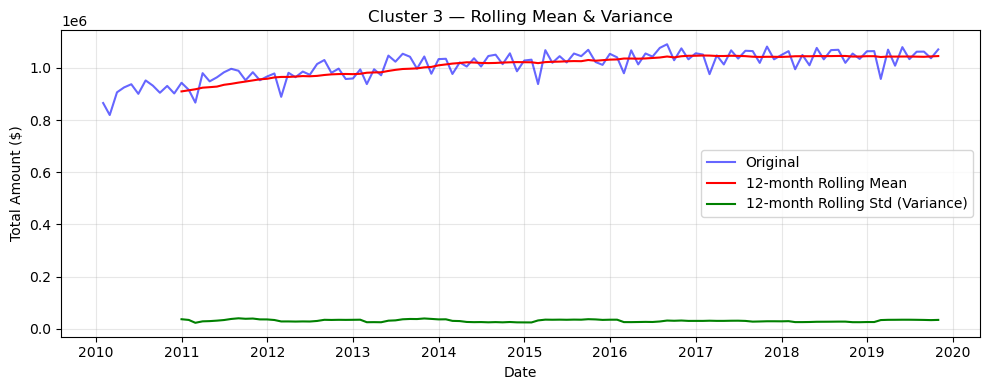

In [11]:
window = 12  # 12-month rolling window
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    rol_mean = sub.rolling(window).mean()
    rol_std  = sub.rolling(window).std()

    plt.figure(figsize=(10,4))
    plt.plot(sub, label='Original', color='blue', alpha=0.6)
    plt.plot(rol_mean, label=f'{window}-month Rolling Mean', color='red')
    plt.plot(rol_std, label=f'{window}-month Rolling Std (Variance)', color='green')
    plt.title(f'Cluster {c} — Rolling Mean & Variance')
    plt.xlabel('Date'); plt.ylabel('Total Amount ($)')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#### 3. Seasonal-Trend Decomposition (STL)

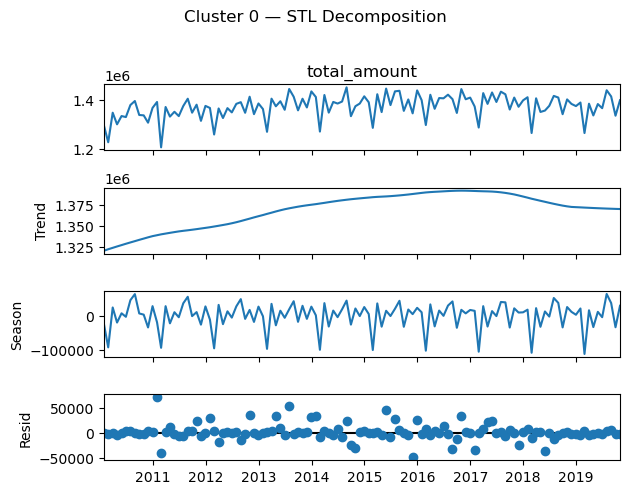

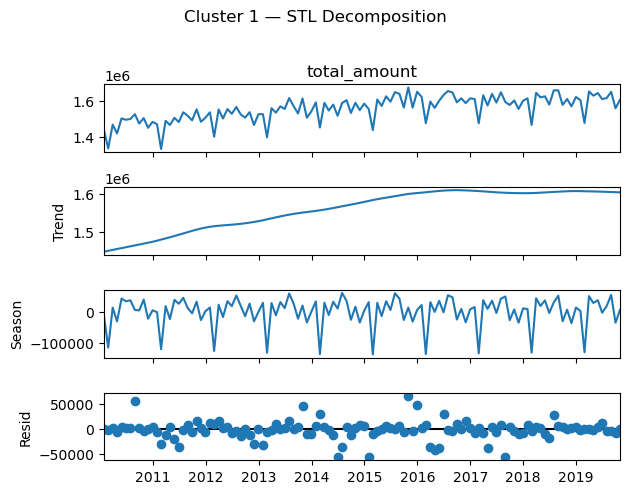

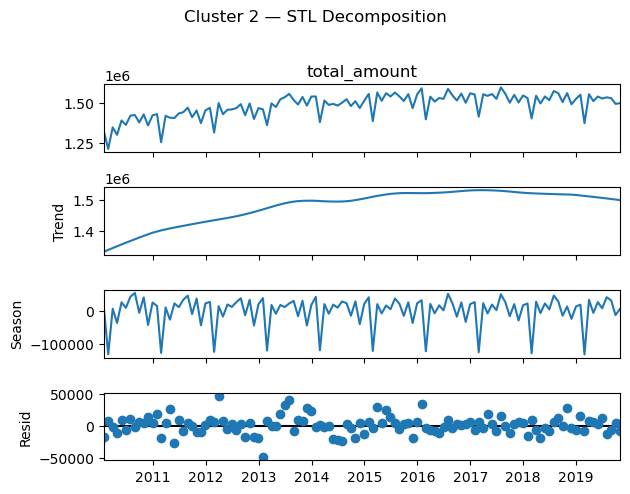

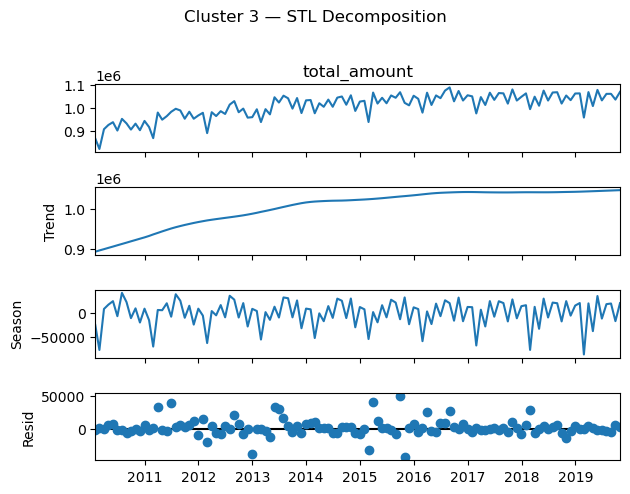

In [12]:
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    sub = sub.asfreq('M')  # ensure regular frequency
    stl = STL(sub, period=12, robust=True)
    res = stl.fit()
    res.plot()
    plt.suptitle(f'Cluster {c} — STL Decomposition', y=1.02)
    plt.tight_layout(); plt.show()

1. **Trend:** slow, upward trend across all clusters
2. **Seasonality:** strong, repeating 12-month pattern in every cluster
3. **Residuals:** randomly scattered

#### Formal Stationarity Check 

In [13]:
def adf_kpss_summary(ts):
    """Return a dict with ADF and KPSS test results for one series."""
    ts = ts.dropna()
    adf_stat, adf_p, *_ = adfuller(ts)
    kpss_stat, kpss_p, *_ = kpss(ts, regression='c', nlags='auto')
    return {
        "ADF_Statistic": adf_stat,
        "ADF_pvalue": adf_p,
        "ADF_Stationary": adf_p < 0.05,
        "KPSS_Statistic": kpss_stat,
        "KPSS_pvalue": kpss_p,
        "KPSS_Stationary": kpss_p > 0.05
    }

# Run tests for all clusters and collect results
rows = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    result = adf_kpss_summary(ts)
    result["Cluster"] = cid
    rows.append(result)

# Convert to DataFrame for a clean table view
results_df = (
    pd.DataFrame(rows)
    .set_index("Cluster")
    .round(3)
)

In [14]:
display(results_df)

,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,
0,-2.7950,0.0590,False,1.1520,0.0100,False
1,-2.1010,0.2440,False,1.7300,0.0100,False
2,-2.5720,0.0990,False,1.5530,0.0100,False
3,-5.6590,0.0000,True,1.7090,0.0100,False


#### Making the series stationary

In [15]:
cluster_monthly_diff1 = (
    cluster_monthly
    .groupby('Cluster', group_keys=False)
    .apply(lambda x: x.set_index('date')['total_amount'].diff().dropna())
)

In [16]:
rows_diff1 = []

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    ts_diff = ts.diff().dropna()   # first differencing (remove trend)
    result = adf_kpss_summary(ts_diff)
    result["Cluster"] = cid
    rows_diff1.append(result)

results_diff1_df = (
    pd.DataFrame(rows_diff1)
    .set_index("Cluster")
    .round(3)
)

display(results_diff1_df)

,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,
0,-12.6840,0.0000,True,0.1630,0.1000,True
1,-3.2440,0.0180,True,0.1730,0.1000,True
2,-2.6510,0.0830,False,0.3520,0.0980,True
3,-3.2690,0.0160,True,0.0920,0.1000,True


In [17]:
final_rows = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    # d=1 for clusters 0/1/3, d=2 for cluster 2
    ts_used = ts.diff().dropna() if cid != 2 else ts.diff().diff().dropna()
    res = adf_kpss_summary(ts_used)
    res["Cluster"] = cid
    res["Used_d"]  = 1 if cid != 2 else 2
    final_rows.append(res)

final_stationarity = (
    pd.DataFrame(final_rows)
      .set_index("Cluster")
      .round(3)
)[["Used_d", "ADF_Statistic", "ADF_pvalue", "ADF_Stationary",
   "KPSS_Statistic", "KPSS_pvalue", "KPSS_Stationary"]]

display(final_stationarity)

,Used_d,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,,
0,1,-12.6840,0.0000,True,0.1630,0.1000,True
1,1,-3.2440,0.0180,True,0.1730,0.1000,True
2,2,-10.9290,0.0000,True,0.3110,0.1000,True
3,1,-3.2690,0.0160,True,0.0920,0.1000,True


#### Finding (p, q)

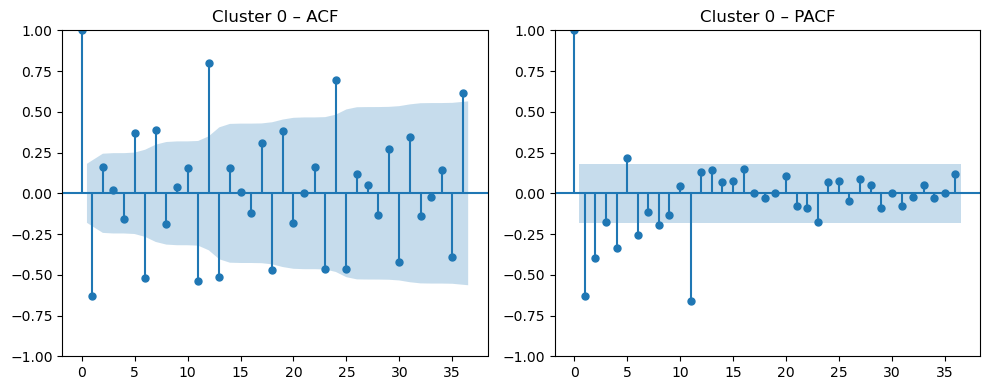

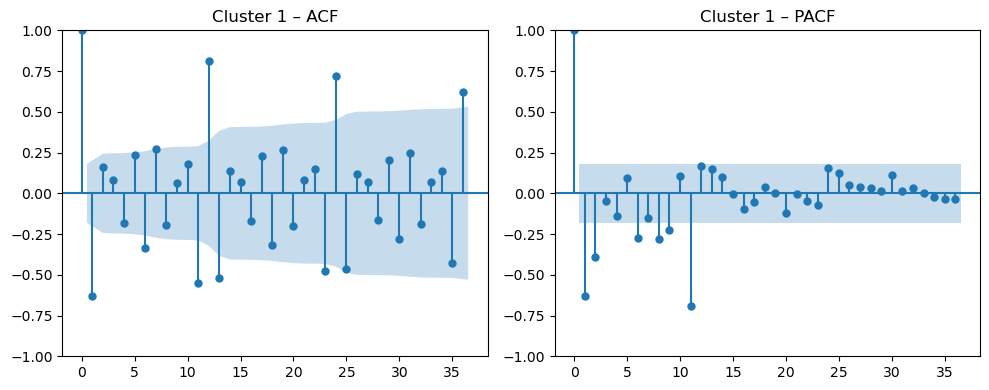

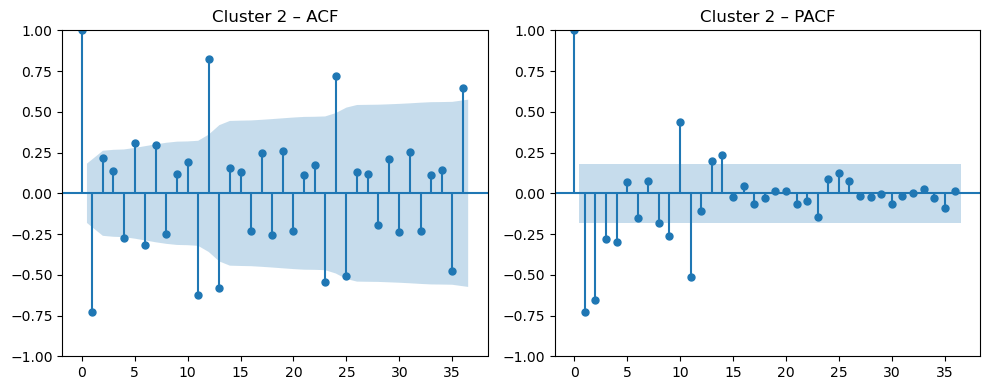

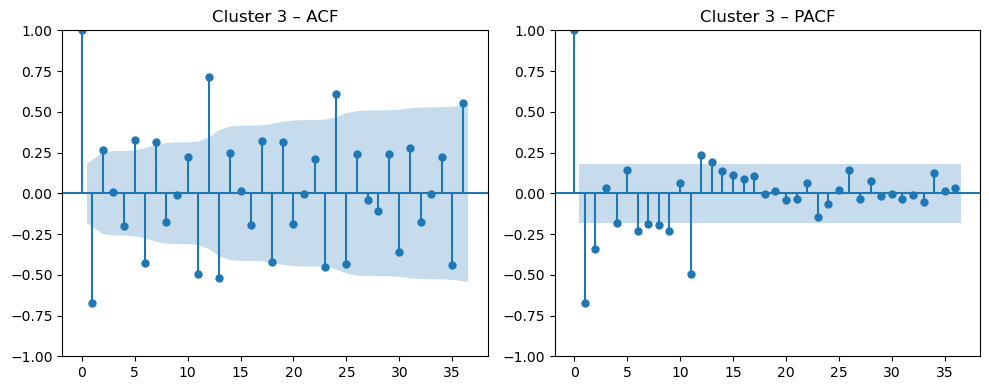

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (cluster_monthly[cluster_monthly["Cluster"] == cid]
          .set_index("date")["total_amount"]
          .asfreq("M"))
    z = ts.diff().dropna() if cid != 2 else ts.diff().diff().dropna()
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plot_acf(z, lags=36, ax=ax[0]); ax[0].set_title(f"Cluster {cid} – ACF")
    plot_pacf(z, lags=36, ax=ax[1], method="ywm"); ax[1].set_title(f"Cluster {cid} – PACF")
    plt.tight_layout(); plt.show()

#### Moving to SARIMA

#### Finding parameter values for SARIMA

In [20]:
d_map = {0:1, 1:1, 2:1, 3:1}
S = 12
p = q = range(0, 3)     # nonseasonal orders
P = Q = range(0, 2)     # seasonal orders
USE_AICC = False        # set True to use AICc instead of BIC

In [21]:
def aicc_from_fit(n, k, aic):
    denom = n - k - 1
    return aic if denom <= 0 else aic + 2 * k * (k + 1) / denom

def try_fit(ts, order, seas_order):
    """Fit SARIMA and return metrics for selection."""
    try:
        res = SARIMAX(
            ts, order=order, seasonal_order=seas_order,
            enforce_stationarity=False, enforce_invertibility=False,
            simple_differencing=True
        ).fit(disp=False)

        resid = res.resid.dropna()
        lb = sm.stats.acorr_ljungbox(resid, lags=[S, 2*S], return_df=True)
        lb_p = float(lb["lb_pvalue"].iloc[-1])
        n = len(ts.dropna())
        k = res.params.size
        bic, aic = res.bic, res.aic
        aicc = aicc_from_fit(n, k, aic)

        return dict(success=True, res=res, bic=bic, aic=aic, aicc=aicc,
                    lb_p=lb_p, k=k)
    except Exception:
        return dict(success=False)

In [22]:
# grid search
rows, best_models = [], {}

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )
    d = d_map[cid]

    cand = []
    for p_, q_, P_, Q_ in itertools.product(p, q, P, Q):
        order = (p_, d, q_)
        seas  = (P_, 0, Q_, S)       # D=0 confirmed
        fit = try_fit(ts, order, seas)
        if fit["success"]:
            fit.update(order=order, seasonal_order=seas)
            cand.append(fit)

    assert len(cand) > 0, f"No models converged for cluster {cid}"

    # (1) prefer white-noise residuals
    ok = [c for c in cand if c["lb_p"] >= 0.05] or cand

    # (2) choose lowest IC; tie-break by fewer params, then AIC
    key_ic = (lambda x: x["aicc"]) if USE_AICC else (lambda x: x["bic"])
    ok.sort(key=lambda c: (key_ic(c), c["k"], c["aic"]))
    best = ok[0]
    best_models[cid] = best["res"]

    rows.append({
        "Cluster": cid,
        "Best_Order": best["order"],
        "Best_Seasonal": best["seasonal_order"],
        "BIC": round(best["bic"], 3),
        "AIC": round(best["aic"], 3),
        "AICc": round(best["aicc"], 3),
        "LB_p(S,2S)": round(best["lb_p"], 3),
        "Num_Params": int(best["k"]),
        "IC_Used": "AICc" if USE_AICC else "BIC"
    })

best_table = pd.DataFrame(rows).set_index("Cluster")
display(best_table)

,Best_Order,Best_Seasonal,BIC,AIC,AICc,"LB_p(S,2S)",Num_Params,IC_Used
Cluster,,,,,,,,
0,"(2, 1, 2)","(1, 0, 1, 12)","2,415.5280","2,397.1540","2,398.1720",0.7380,7,BIC
1,"(2, 1, 2)","(1, 0, 1, 12)","2,457.3010","2,438.9260","2,439.9450",0.6080,7,BIC
2,"(2, 1, 2)","(1, 0, 1, 12)","2,437.5590","2,419.1840","2,420.2020",0.7460,7,BIC
3,"(2, 1, 2)","(1, 0, 1, 12)","2,361.0030","2,342.6280","2,343.6460",0.6320,7,BIC


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np, pandas as pd

def rolling_forecast(ts, order, seasonal_order, train_len=84, horizon=1, step=1):
    """Rolling/sliding window 1-step forecast evaluation."""
    ts = ts.dropna()
    n = len(ts)
    preds, actuals = [], []

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test  = ts.iloc[start + train_len : start + train_len + horizon]

        try:
            model = SARIMAX(
                train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            fc = model.forecast(steps=horizon)
            preds.append(fc.values[0])
            actuals.append(test.values[0])
        except Exception:
            preds.append(np.nan)
            actuals.append(np.nan)

    df = pd.DataFrame({"Actual": actuals, "Pred": preds}).dropna()
    return df

# Example usage per cluster:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

results = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )

    df_fc = rolling_forecast(ts,
                             order=(2,1,2),
                             seasonal_order=(1,0,1,12),
                             train_len=84,  # 7 years
                             horizon=1, step=1)

    rmse = np.sqrt(mean_absolute_error(df_fc["Actual"], df_fc["Pred"]))
    mape = mean_absolute_percentage_error(df_fc["Actual"], df_fc["Pred"]) * 100

    results.append({"Cluster": cid, "RMSE": rmse, "MAPE (%)": mape})

pd.DataFrame(results)

,Cluster,RMSE,MAPE (%)
0,0,159.1953,1.8371
1,1,160.7053,1.6073
2,2,131.9032,1.1519
3,3,117.0305,1.3270


#### Model

In [24]:
def rolling_forecast(ts, order, seasonal_order, train_len=84, horizon=1, step=1):
    """Perform rolling/sliding 1-step forecasts."""
    ts = ts.dropna()
    n = len(ts)
    preds, actuals = [], []

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test  = ts.iloc[start + train_len : start + train_len + horizon]

        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            fc = model.forecast(steps=horizon)
            preds.append(fc.values[0])
            actuals.append(test.values[0])

        except Exception:
            preds.append(np.nan)
            actuals.append(np.nan)

    df = pd.DataFrame({"Actual": actuals, "Pred": preds}).dropna()
    return df

# ---- Run evaluation for all clusters ----
results = []

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )

    # rolling 1-step forecast per cluster
    df_fc = rolling_forecast(
        ts,
        order=(2,1,2),
        seasonal_order=(1,0,1,12),
        train_len=84,   # 7 years training
        horizon=1,
        step=1
    )

    # Compute metrics
    mae  = mean_absolute_error(df_fc["Actual"], df_fc["Pred"])
    mse  = mean_squared_error(df_fc["Actual"], df_fc["Pred"])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(df_fc["Actual"], df_fc["Pred"]) * 100

    results.append({
        "Cluster": cid,
        "n_forecasts": len(df_fc),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2)
    })

# Summary table
metrics_df = pd.DataFrame(results).set_index("Cluster")
display(metrics_df)

,n_forecasts,MAE,MSE,RMSE,MAPE (%)
Cluster,,,,,
0,34,"25,343.1400","1,091,863,456.5200","33,043.3600",1.8400
1,34,"25,826.1900","1,060,065,059.7800","32,558.6400",1.6100
2,34,"17,398.4500","494,498,310.7000","22,237.3200",1.1500
3,34,"13,696.1400","337,375,047.0200","18,367.7700",1.3300


In [27]:
cluster_count = df['Cluster'].value_counts()

In [28]:
cluster_count

Cluster
1    4594314
0    3437186
2    2572134
3    2031593
Name: count, dtype: int64

In [30]:
# Example: replace with your actual cluster sizes
cluster_sizes = {0: 3437186, 1: 4594314, 2: 2572134, 3: 2031593}

# Add normalized metrics
metrics_df["Cluster_Size"] = metrics_df.index.map(cluster_sizes)
metrics_df["MAE_per_person"]  = metrics_df["MAE"]  / metrics_df["Cluster_Size"]
metrics_df["RMSE_per_person"] = metrics_df["RMSE"] / metrics_df["Cluster_Size"]

# Optional rounding for readability
metrics_df = metrics_df.round({
    "MAE_per_person": 5,
    "RMSE_per_person": 5
})

display(metrics_df)

,n_forecasts,MAE,MSE,RMSE,MAPE (%),Cluster_Size,MAE_per_person,RMSE_per_person
Cluster,,,,,,,,
0,34,"25,343.1400","1,091,863,456.5200","33,043.3600",1.8400,3437186,0.0074,0.0096
1,34,"25,826.1900","1,060,065,059.7800","32,558.6400",1.6100,4594314,0.0056,0.0071
2,34,"17,398.4500","494,498,310.7000","22,237.3200",1.1500,2572134,0.0068,0.0086
3,34,"13,696.1400","337,375,047.0200","18,367.7700",1.3300,2031593,0.0067,0.0090


#### Actual vs Predicted (per cluster)

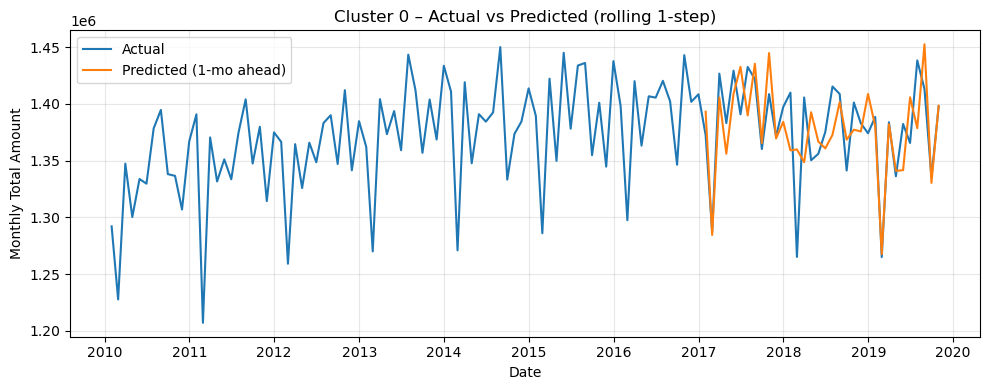

In [32]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(ts, order, seasonal_order, train_len=84, title_prefix=""):
    # Get rolling 1-step forecasts and align to time
    df_fc = rolling_forecast(ts, order, seasonal_order, train_len=train_len, horizon=1, step=1)
    # predictions correspond to the last len(df_fc) timestamps
    pred_index = ts.index[-len(df_fc):]
    df_fc = df_fc.set_index(pred_index)

    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, label="Actual", linewidth=1.5)
    plt.plot(df_fc.index, df_fc["Pred"].values, label="Predicted (1-mo ahead)", linewidth=1.5)
    plt.title(f"{title_prefix}Actual vs Predicted (rolling 1-step)")
    plt.xlabel("Date"); plt.ylabel("Monthly Total Amount")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

# Example for one cluster
cid = 0
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=84, title_prefix=f"Cluster {cid} – ")

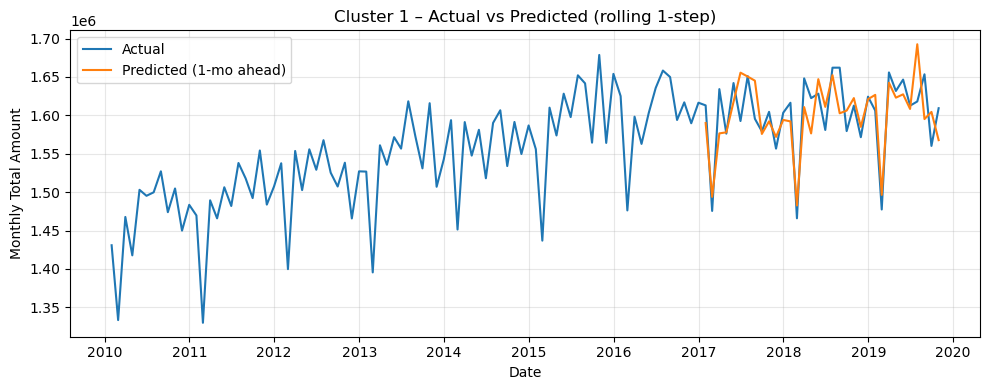

In [33]:
cid = 1
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=84, title_prefix=f"Cluster {cid} – ")

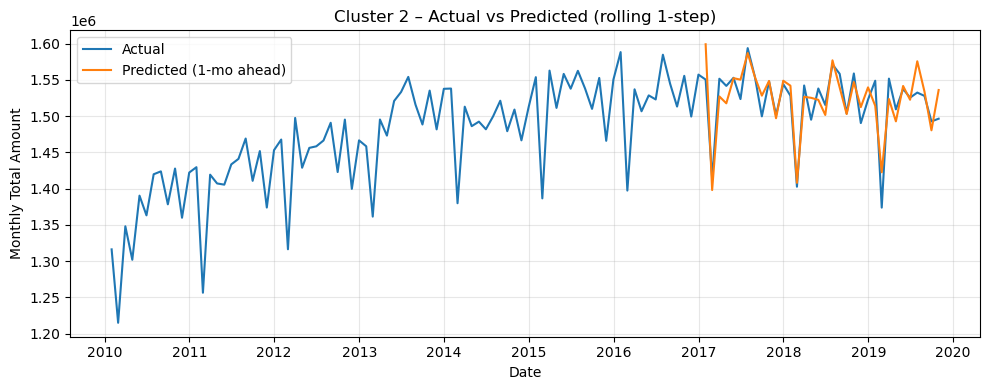

In [34]:
cid = 2
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=84, title_prefix=f"Cluster {cid} – ")

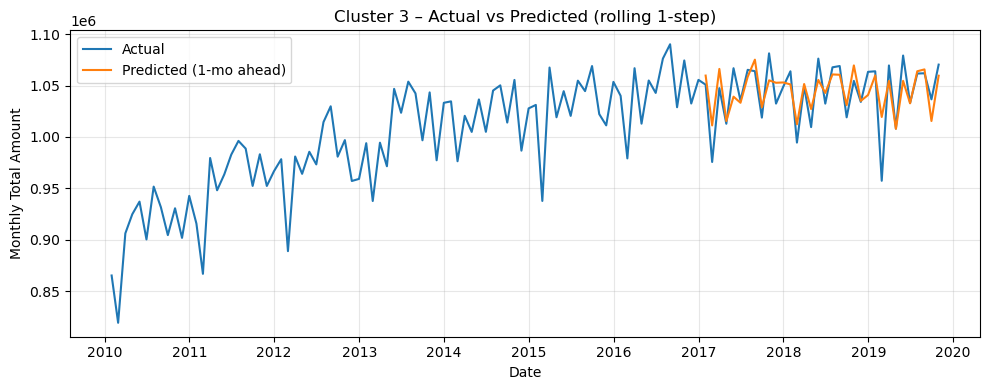

In [35]:
# Example for one cluster
cid = 3
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=84, title_prefix=f"Cluster {cid} – ")

#### All clusters overlay grid

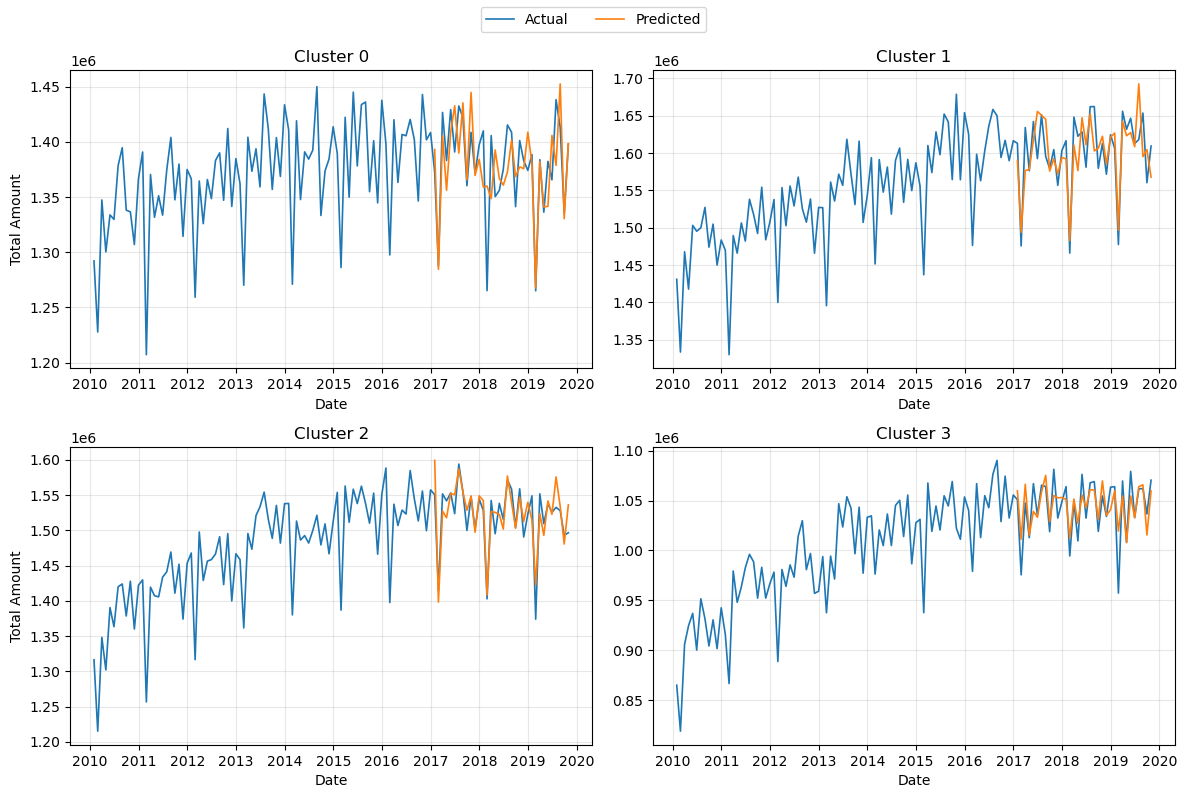

In [36]:
def plot_all_clusters_overlays(cluster_monthly, order, seasonal_order, train_len=84):
    cids = sorted(cluster_monthly["Cluster"].unique())
    n = len(cids)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)
    for i, cid in enumerate(cids):
        ax = axes[i // cols][i % cols]
        ts = (cluster_monthly.query("Cluster == @cid")
              .set_index("date")["total_amount"].asfreq("M").dropna())

        df_fc = rolling_forecast(ts, order, seasonal_order, train_len=train_len, horizon=1, step=1)
        pred_index = ts.index[-len(df_fc):]
        df_fc = df_fc.set_index(pred_index)

        ax.plot(ts.index, ts.values, label="Actual", linewidth=1.2)
        ax.plot(df_fc.index, df_fc["Pred"].values, label="Predicted", linewidth=1.2)
        ax.set_title(f"Cluster {cid}")
        ax.grid(alpha=0.3)
        if i % cols == 0: ax.set_ylabel("Total Amount")
        ax.set_xlabel("Date")

    # one legend for all
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_all_clusters_overlays(cluster_monthly, order=(2,1,2), seasonal_order=(1,0,1,12), train_len=84)

#### Bar charts for metrics across clusters

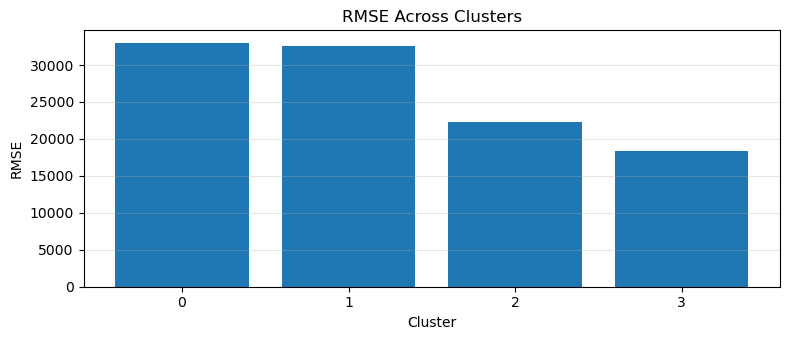

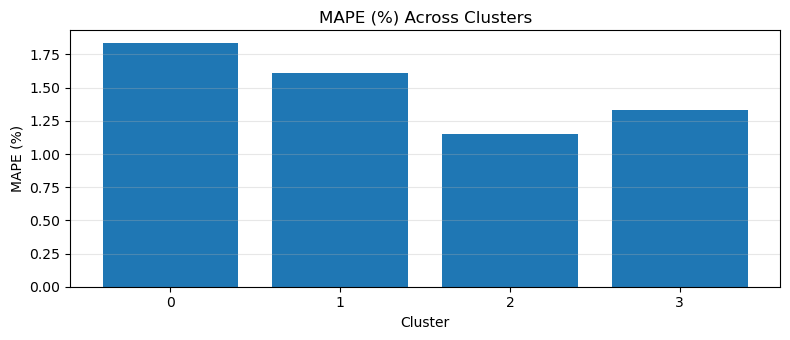

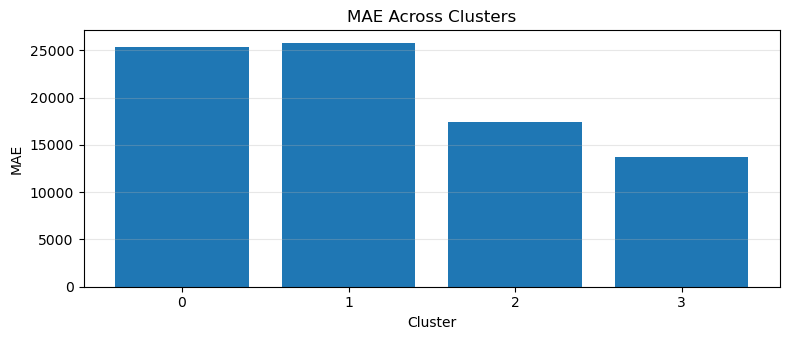

In [37]:
def plot_metric_bars(metrics_df):
    clusters = list(metrics_df.index.astype(str))

    # RMSE
    plt.figure(figsize=(8,3.5))
    plt.bar(clusters, metrics_df["RMSE"].values)
    plt.title("RMSE Across Clusters"); plt.xlabel("Cluster"); plt.ylabel("RMSE")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

    # MAPE
    plt.figure(figsize=(8,3.5))
    plt.bar(clusters, metrics_df["MAPE (%)"].values)
    plt.title("MAPE (%) Across Clusters"); plt.xlabel("Cluster"); plt.ylabel("MAPE (%)")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

    # MAE (optional)
    plt.figure(figsize=(8,3.5))
    plt.bar(clusters, metrics_df["MAE"].values)
    plt.title("MAE Across Clusters"); plt.xlabel("Cluster"); plt.ylabel("MAE")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

plot_metric_bars(metrics_df)

#### Per-person normalized bars

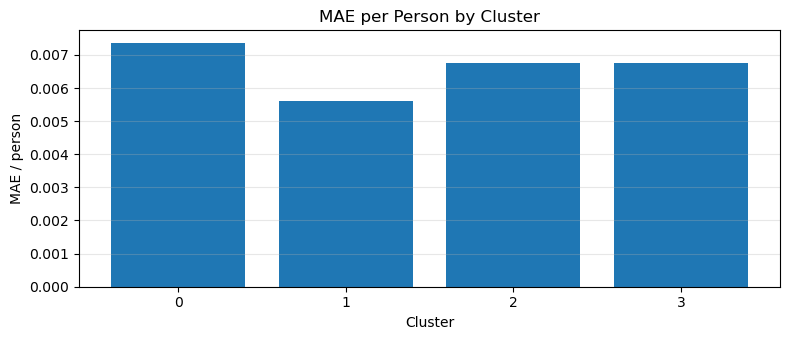

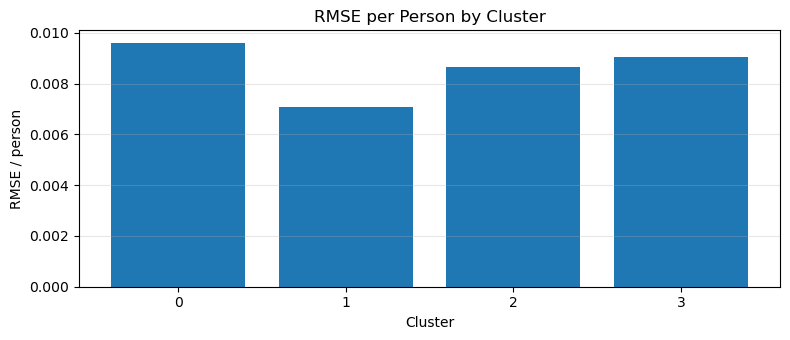

In [38]:
def plot_per_person_bars(metrics_df, cluster_sizes):
    df = metrics_df.copy()
    df["Cluster_Size"] = df.index.map(cluster_sizes)
    df["MAE/person"]  = df["MAE"]  / df["Cluster_Size"]
    df["RMSE/person"] = df["RMSE"] / df["Cluster_Size"]

    clusters = list(df.index.astype(str))

    plt.figure(figsize=(8,3.5))
    plt.bar(clusters, df["MAE/person"].values)
    plt.title("MAE per Person by Cluster"); plt.xlabel("Cluster"); plt.ylabel("MAE / person")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3.5))
    plt.bar(clusters, df["RMSE/person"].values)
    plt.title("RMSE per Person by Cluster"); plt.xlabel("Cluster"); plt.ylabel("RMSE / person")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

plot_per_person_bars(metrics_df, cluster_sizes)